In [ ]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

## Question 1

In [ ]:
# Read CSV files - 17 Industry Portfolios (Value-Weighted Returns)

# Option 1: Lire avec les en-têtes de la ligne 12
df_17_vw = pd.read_csv('17_Industry_Portfolios.csv', skiprows=11, nrows=1191)

# Vérifier les premières lignes
print("Premières lignes du fichier 17 Industry Portfolios:")
print(df_17_vw.head())
print(f"\nShape: {df_17_vw.shape}")

df_17_vw

Premières lignes du fichier 17 Industry Portfolios:
   Unnamed: 0  Food  Mines   Oil  Clths  Durbl  Chems  Cnsum  Cnstr  Steel  \
0      192607  0.51   3.75 -1.37   6.05  -1.62   8.48   1.41   2.32   4.06   
1      192608  3.06   0.72  3.55   0.13  -1.96   5.66   5.86   4.33   2.18   
2      192609  1.32   1.11 -3.58   0.27   0.23   5.57   1.22  -0.08   0.16   
3      192610 -3.15  -0.78 -1.02   0.36  -6.05  -4.76   0.69  -4.78  -3.85   
4      192611  6.53   4.38 -0.01   2.24  -1.95   5.25   4.64   2.45   4.21   

   FabPr  Machn   Cars  Trans  Utils  Rtail  Finan  Other  
0   8.79   3.79  15.36   1.84   7.04   0.14  -0.02   1.16  
1  -5.60   2.36   3.98   4.54  -1.70  -0.69   4.26   3.03  
2  -4.13  -0.66   5.77   0.33   2.05   0.21  -1.63   1.75  
3  -5.14  -3.34  -8.47  -2.91  -3.27  -2.25  -5.52  -0.92  
4   3.57   4.59  -0.26   2.20   4.40   6.46   2.54   1.50  

Shape: (1191, 18)


,Unnamed: 0,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
0,192607,0.51,3.75,-1.37,6.05,-1.62,8.48,1.41,2.32,4.06,8.79,3.79,15.36,1.84,7.04,0.14,-0.02,1.16
1,192608,3.06,0.72,3.55,0.13,-1.96,5.66,5.86,4.33,2.18,-5.60,2.36,3.98,4.54,-1.70,-0.69,4.26,3.03
2,192609,1.32,1.11,-3.58,0.27,0.23,5.57,1.22,-0.08,0.16,-4.13,-0.66,5.77,0.33,2.05,0.21,-1.63,1.75
3,192610,-3.15,-0.78,-1.02,0.36,-6.05,-4.76,0.69,-4.78,-3.85,-5.14,-3.34,-8.47,-2.91,-3.27,-2.25,-5.52,-0.92
4,192611,6.53,4.38,-0.01,2.24,-1.95,5.25,4.64,2.45,4.21,3.57,4.59,-0.26,2.20,4.40,6.46,2.54,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,202505,-0.70,3.08,1.83,9.60,3.35,2.60,-4.64,2.80,3.97,11.67,16.01,15.74,8.08,3.43,6.62,4.30,5.82
1187,202506,-1.15,8.23,5.24,2.14,4.33,1.69,0.62,2.72,10.43,6.33,13.65,-5.89,4.94,1.01,2.91,5.51,4.58
1188,202507,-0.25,0.92,3.56,2.41,2.55,1.00,-2.42,3.29,3.42,0.37,7.68,-0.92,0.92,3.37,2.57,-0.68,1.94
1189,202508,1.71,11.08,4.26,4.88,7.21,5.02,3.76,8.54,4.22,1.11,0.10,8.12,2.57,-1.59,-0.58,4.18,2.20


In [ ]:
# F-F Momentum Factor - Données mensuelles uniquement

df_FF = pd.read_csv('F-F_Momentum_Factor.csv', skiprows=13)

# Nettoyer et filtrer pour garder uniquement les données mensuelles
df_FF.columns = df_FF.columns.str.strip()
df_FF = df_FF.rename(columns={df_FF.columns[0]: 'Date'})

# Convertir Date en string
df_FF['Date'] = df_FF['Date'].astype(str).str.strip()

# Garder uniquement les lignes avec format mensuel (AAAAMM = 6 caractères)
df_FF = df_FF[df_FF['Date'].str.len() == 6]

print(f"Momentum Factor (données mensuelles): {df_FF.shape[0]} lignes")
print(f"Première date: {df_FF['Date'].iloc[0]}, Dernière date: {df_FF['Date'].iloc[-1]}")

df_FF

Momentum Factor (données mensuelles): 1185 lignes
Première date: 192701, Dernière date: 202509


,Date,Mom
0,192701,0.57
1,192702,-1.50
2,192703,3.52
3,192704,4.36
4,192705,2.78
...,...,...
1180,202505,2.21
1181,202506,-2.64
1182,202507,-0.96
1183,202508,-3.54


In [ ]:
# F-F 5 Factors - Données mensuelles uniquement
 
df_FF5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)

# Nettoyer et filtrer pour garder uniquement les données mensuelles
df_FF5.columns = df_FF5.columns.str.strip()
df_FF5 = df_FF5.rename(columns={df_FF5.columns[0]: 'Date'})

# Convertir Date en string
df_FF5['Date'] = df_FF5['Date'].astype(str).str.strip()

# Garder uniquement les lignes avec format mensuel (AAAAMM = 6 caractères)
df_FF5 = df_FF5[df_FF5['Date'].str.len() == 6]

print(f"Fama-French 5 Factors (données mensuelles): {df_FF5.shape[0]} lignes")
print(f"Première date: {df_FF5['Date'].iloc[0]}, Dernière date: {df_FF5['Date'].iloc[-1]}")

df_FF5

Fama-French 5 Factors (données mensuelles): 747 lignes
Première date: 196307, Dernière date: 202509


,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.48,-0.81,0.64,-1.15,0.27
1,196308,5.08,-0.80,1.70,0.40,-0.38,0.25
2,196309,-1.57,-0.43,0.00,-0.78,0.15,0.27
3,196310,2.54,-1.34,-0.04,2.79,-2.25,0.29
4,196311,-0.86,-0.85,1.73,-0.43,2.27,0.27
...,...,...,...,...,...,...,...
742,202505,6.06,-0.72,-2.88,1.29,2.51,0.38
743,202506,4.86,-0.02,-1.60,-3.20,1.45,0.34
744,202507,1.98,-0.15,-1.27,-0.29,-2.08,0.34
745,202508,1.85,4.88,4.42,-0.68,2.07,0.38


In [ ]:
# Fusion des trois fichiers CSV - 6 facteurs + 17 portefeuilles sectoriels (1980-2021)

# 1. Préparer les 17 Industry Portfolios (Value-Weighted)
df_17_clean = df_17_vw.copy()
df_17_clean.columns = df_17_clean.columns.str.strip()
df_17_clean = df_17_clean.rename(columns={df_17_clean.columns[0]: 'Date'})
df_17_clean['Date'] = df_17_clean['Date'].astype(str).str.strip()
df_17_clean = df_17_clean[df_17_clean['Date'].str.len() == 6]
df_17_clean = df_17_clean[(df_17_clean['Date'] >= '198001') & (df_17_clean['Date'] <= '202112')].copy()

for col in df_17_clean.columns[1:]:
    df_17_clean[col] = pd.to_numeric(df_17_clean[col], errors='coerce')

# 2. Préparer les 5 facteurs Fama-French
df_FF5_clean = df_FF5[(df_FF5['Date'] >= '198001') & (df_FF5['Date'] <= '202112')].copy()

for col in df_FF5_clean.columns[1:]:
    df_FF5_clean[col] = pd.to_numeric(df_FF5_clean[col], errors='coerce')

# 3. Préparer le facteur Momentum
df_Mom_clean = df_FF[(df_FF['Date'] >= '198001') & (df_FF['Date'] <= '202112')].copy()

for col in df_Mom_clean.columns[1:]:
    df_Mom_clean[col] = pd.to_numeric(df_Mom_clean[col], errors='coerce')

# 4. Fusionner : 5 facteurs + Momentum = 6 facteurs
df_6factors = pd.merge(df_FF5_clean, df_Mom_clean, on='Date', how='inner')

# 5. Fusionner : 6 facteurs + 17 secteurs = Dataset final
df_final = pd.merge(df_6factors, df_17_clean, on='Date', how='inner')

# Résumé
print(f"Dataset final: {df_final.shape[0]} mois × {df_final.shape[1]} colonnes")
print(f"Période: {df_final['Date'].iloc[0]} à {df_final['Date'].iloc[-1]}")
print(f"\nColonnes: {list(df_final.columns)}")

df_final


Dataset final: 504 mois × 25 colonnes
Période: 198001 à 202112

Colonnes: ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom', 'Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']


,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,Food,Mines,...,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
0,198001,5.50,1.88,1.85,-1.84,1.89,0.80,7.45,3.86,14.09,...,8.61,17.58,7.22,7.74,10.76,15.87,1.55,0.17,2.11,3.90
1,198002,-1.23,-1.62,0.59,-0.95,2.92,0.89,7.89,-5.29,3.78,...,-2.12,0.29,-1.02,-3.85,-6.53,-6.48,-3.42,-5.37,-5.02,-1.37
2,198003,-12.89,-6.97,-0.96,1.82,-1.05,1.21,-9.58,-9.03,-21.14,...,-14.87,-18.49,-16.71,-12.77,-9.56,-12.94,-6.60,-8.05,-8.92,-9.81
3,198004,3.96,1.05,1.03,-2.18,0.34,1.26,-0.48,7.05,2.36,...,4.03,2.30,3.95,0.10,-2.89,-0.62,12.04,4.76,6.88,6.52
4,198005,5.26,2.00,0.38,0.43,-0.63,0.81,-1.18,7.97,9.99,...,8.87,5.20,5.70,4.88,3.13,5.87,4.60,10.26,7.87,6.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,202108,2.95,-0.66,-0.23,-0.26,-1.72,0.00,2.63,-0.41,-2.59,...,1.82,3.51,5.29,3.52,1.98,-0.67,3.23,3.02,2.86,3.93
500,202109,-4.40,1.12,5.12,-1.92,2.00,0.00,1.39,-3.39,-8.11,...,-3.71,-10.64,-5.68,-5.72,4.04,-2.11,-4.87,-5.43,-1.54,-5.74
501,202110,6.63,-2.70,-0.53,1.71,-1.54,0.00,3.32,3.42,8.68,...,11.42,10.14,3.71,7.57,30.82,6.06,5.11,3.77,7.07,5.51
502,202111,-1.58,-1.70,-0.37,7.19,1.70,0.00,0.96,-2.92,-0.18,...,5.31,-6.28,0.25,6.76,2.70,-5.46,-1.97,1.16,-5.68,-2.84


In [ ]:
# Créer les rendements excédentaires pour les 17 secteurs
# Les rendements dans le fichier 17 Industry Portfolios sont des rendements BRUTS
# Pour le modèle de régression, nous avons besoin de : Rendement Sectoriel - RF

# Identifier les colonnes des 17 secteurs (toutes sauf Date et les facteurs)
facteur_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom']
secteur_cols = [col for col in df_final.columns if col not in ['Date'] + facteur_cols]

print(f"Colonnes des facteurs: {facteur_cols}")
print(f"\nColonnes des 17 secteurs: {secteur_cols}")

# Créer un DataFrame avec les rendements excédentaires
df_excess = df_final.copy()

# Pour chaque secteur, calculer le rendement excédentaire = Rendement - RF
for secteur in secteur_cols:
    df_excess[f'{secteur}_excess'] = df_final[secteur] - df_final['RF']

# Vérification
print(f"\nExemple de calcul des rendements excédentaires:")
print(f"Secteur 'Food' - rendement brut: {df_final['Food'].iloc[0]:.2f}%")
print(f"RF: {df_final['RF'].iloc[0]:.2f}%")
print(f"Rendement excédentaire: {df_excess['Food_excess'].iloc[0]:.2f}%")

# Afficher les premières lignes
print(f"\nPremières lignes avec rendements excédentaires:")

df_excess.info()


Colonnes des facteurs: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom']

Colonnes des 17 secteurs: ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']

Exemple de calcul des rendements excédentaires:
Secteur 'Food' - rendement brut: 3.86%
RF: 0.80%
Rendement excédentaire: 3.06%

Premières lignes avec rendements excédentaires:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 42 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          504 non-null    object 
 1   Mkt-RF        504 non-null    float64
 2   SMB           504 non-null    float64
 3   HML           504 non-null    float64
 4   RMW           504 non-null    float64
 5   CMA           504 non-null    float64
 6   RF            504 non-null    float64
 7   Mom           504 non-null    float64
 8   Food          504 non-null    f

In [ ]:
# Créer le DataFrame final avec rendements excédentaires des 17 secteurs + 6 facteurs + RF + Date

# 1. Colonnes à garder : Date, 6 facteurs, RF
cols_to_keep = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom', 'RF']

# 2. Créer le DataFrame de base avec Date, facteurs et RF
df_final_excess = df_excess[cols_to_keep].copy()

# 3. Ajouter les rendements excédentaires des 17 secteurs
for secteur in secteur_cols:
    df_final_excess[secteur] = df_excess[f'{secteur}_excess']

# Résumé
print(f"DataFrame final avec rendements excédentaires:")
print(f"Dimensions: {df_final_excess.shape[0]} mois × {df_final_excess.shape[1]} colonnes")
print(f"Période: {df_final_excess['Date'].iloc[0]} à {df_final_excess['Date'].iloc[-1]}")

print(f"\nColonnes ({len(df_final_excess.columns)} au total):")
print(f"- Date: 1")
print(f"- Facteurs (6): Mkt-RF, SMB, HML, RMW, CMA, Mom")
print(f"- RF: 1")
print(f"- Secteurs avec rendements excédentaires (17): {secteur_cols}")

print(f"\nPremières lignes:")
df_final_excess.head(10)


DataFrame final avec rendements excédentaires:
Dimensions: 504 mois × 25 colonnes
Période: 198001 à 202112

Colonnes (25 au total):
- Date: 1
- Facteurs (6): Mkt-RF, SMB, HML, RMW, CMA, Mom
- RF: 1
- Secteurs avec rendements excédentaires (17): ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']

Premières lignes:


,Date,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,Food,Mines,...,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
0,198001,5.50,1.88,1.85,-1.84,1.89,7.45,0.80,3.06,13.29,...,7.81,16.78,6.42,6.94,9.96,15.07,0.75,-0.63,1.31,3.10
1,198002,-1.23,-1.62,0.59,-0.95,2.92,7.89,0.89,-6.18,2.89,...,-3.01,-0.60,-1.91,-4.74,-7.42,-7.37,-4.31,-6.26,-5.91,-2.26
2,198003,-12.89,-6.97,-0.96,1.82,-1.05,-9.58,1.21,-10.24,-22.35,...,-16.08,-19.70,-17.92,-13.98,-10.77,-14.15,-7.81,-9.26,-10.13,-11.02
3,198004,3.96,1.05,1.03,-2.18,0.34,-0.48,1.26,5.79,1.10,...,2.77,1.04,2.69,-1.16,-4.15,-1.88,10.78,3.50,5.62,5.26
4,198005,5.26,2.00,0.38,0.43,-0.63,-1.18,0.81,7.16,9.18,...,8.06,4.39,4.89,4.07,2.32,5.06,3.79,9.45,7.06,5.52
5,198006,2.97,1.46,-0.80,-0.20,-0.81,1.58,0.61,1.70,10.09,...,4.37,1.80,4.61,3.25,1.47,0.53,3.94,1.74,4.22,1.21
6,198007,6.51,3.74,-6.29,4.06,-2.44,0.29,0.53,5.30,8.73,...,12.27,12.21,9.46,14.06,12.14,13.50,-0.65,10.09,2.67,6.97
7,198008,1.75,4.23,-2.46,2.05,-0.73,3.06,0.64,0.02,5.95,...,0.69,0.48,1.54,1.78,2.50,0.51,-1.81,-0.18,1.20,3.57
8,198009,2.19,0.63,-4.61,1.90,-2.86,5.43,0.75,-0.97,11.55,...,0.91,3.83,3.06,1.86,0.74,2.33,-0.63,-1.20,1.81,1.22
9,198010,1.04,2.21,-2.93,1.77,-1.43,7.13,0.95,-1.89,-1.26,...,2.03,-1.98,4.40,1.16,-6.49,0.82,0.97,-2.42,-0.85,0.05


### Observations et Différences Notables

**Observations clés sur les séries:**

1. **Volatilité:** Les secteurs et facteurs montrent des niveaux de volatilité différents
2. **Tendances:** Présence de périodes de crises (2008, 2020) visibles sur tous les graphiques
3. **Corrélations:** Certains secteurs semblent plus corrélés au facteur de marché (Mkt-RF) que d'autres
4. **Asymétrie:** Skewness et kurtosis indiquent des distributions non-normales pour plusieurs séries

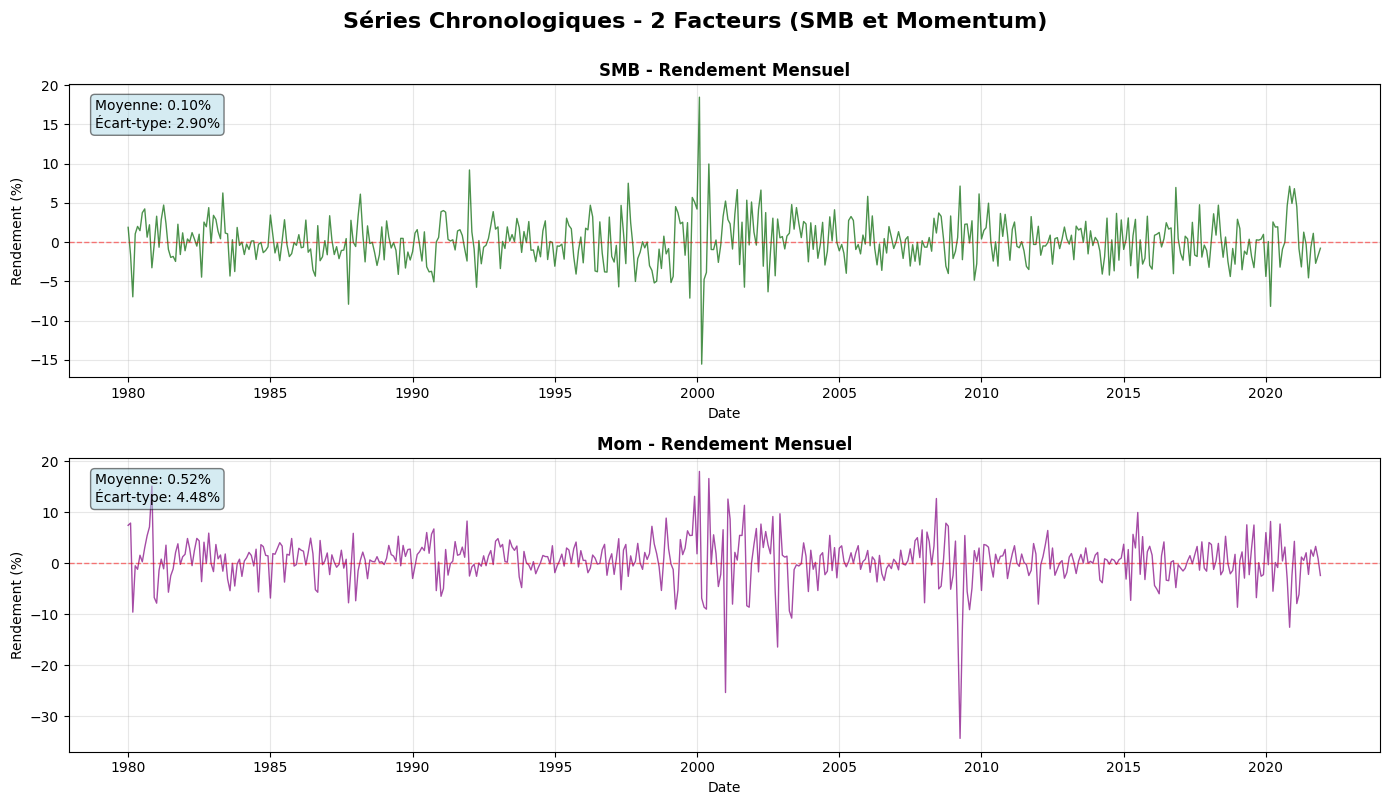

Statistiques pour les 2 facteurs sélectionnés:
           SMB      Mom
count  504.000  504.000
mean     0.095    0.524
std      2.896    4.479
min    -15.540  -34.340
25%     -1.588   -1.192
50%      0.005    0.605
75%      1.872    2.840
max     18.460   18.020


In [ ]:
# Graphiques pour 2 facteurs : SMB (Size) et Mom (Momentum)
# Convertir Date en datetime si ce n'est pas déjà fait
if 'Date_dt' not in df_final_excess.columns:
    df_final_excess['Date_dt'] = pd.to_datetime(df_final_excess['Date'], format='%Y%m')

facteurs_a_afficher = ['SMB', 'Mom']

fig, axes = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Séries Chronologiques - 2 Facteurs (SMB et Momentum)', 
             fontsize=16, fontweight='bold', y=1.00)

couleurs = ['darkgreen', 'purple']

for i, facteur in enumerate(facteurs_a_afficher):
    axes[i].plot(df_final_excess['Date_dt'], df_final_excess[facteur], 
                 linewidth=1, color=couleurs[i], alpha=0.7)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[i].set_title(f'{facteur} - Rendement Mensuel', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement (%)')
    axes[i].grid(True, alpha=0.3)
    
    # Ajouter statistiques sur le graphique
    mean_val = df_final_excess[facteur].mean()
    std_val = df_final_excess[facteur].std()
    axes[i].text(0.02, 0.95, f'Moyenne: {mean_val:.2f}%\nÉcart-type: {std_val:.2f}%',
                transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Statistiques pour les 2 facteurs sélectionnés:")
print(df_final_excess[facteurs_a_afficher].describe().round(3))


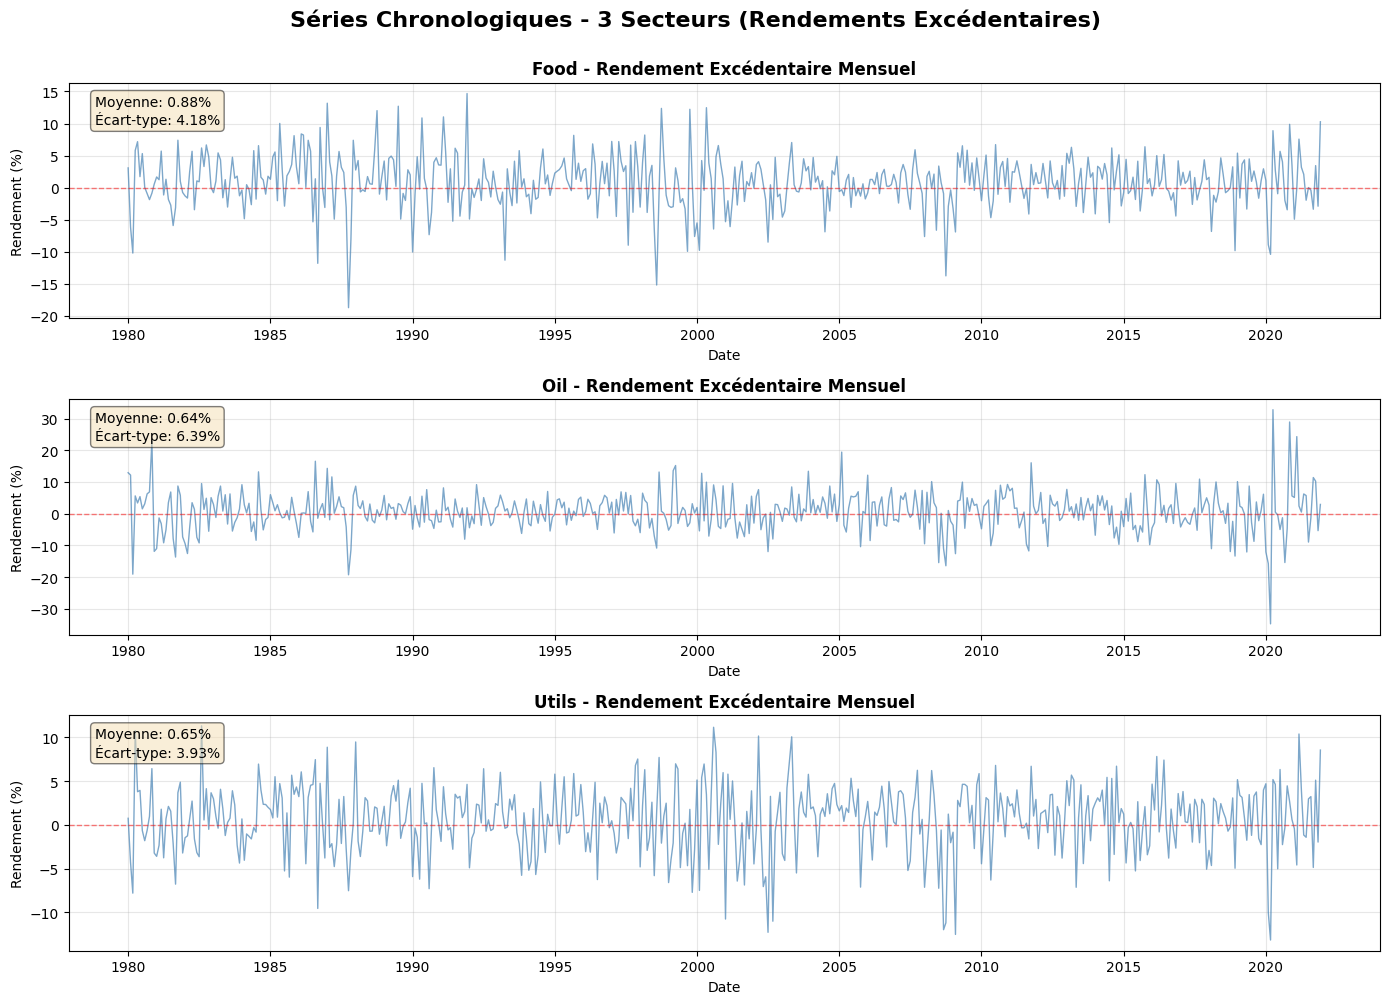

Statistiques pour les 3 secteurs sélectionnés:
          Food      Oil    Utils
count  504.000  504.000  504.000
mean     0.880    0.643    0.646
std      4.176    6.394    3.925
min    -18.770  -34.780  -13.170
25%     -1.310   -2.770   -1.578
50%      0.960    0.760    0.960
75%      3.422    4.283    3.230
max     14.680   32.800   11.320


In [ ]:
# Convertir Date en format datetime pour les graphiques
df_final_excess['Date_dt'] = pd.to_datetime(df_final_excess['Date'], format='%Y%m')

# Graphiques individuels pour 3 secteurs : Food, Oil, Utils
secteurs_a_afficher = ['Food', 'Oil', 'Utils']

# Calculer les limites communes de l'axe Y pour tous les secteurs
y_min = min([df_final_excess[s].min() for s in secteurs_a_afficher])
y_max = max([df_final_excess[s].max() for s in secteurs_a_afficher])
# Ajouter une marge de 5%
y_margin = (y_max - y_min) * 0.05
y_lim = [y_min - y_margin, y_max + y_margin]

# Graphique 1 : Food
fig = plt.figure(figsize=(12, 5))
plt.plot(df_final_excess['Date_dt'], df_final_excess['Food'], 
         linewidth=1.5, color='steelblue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Food - Rendement Excédentaire Mensuel', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rendement (%)', fontsize=12)
plt.ylim(y_lim)
plt.grid(True, alpha=0.3)

# Ajouter statistiques
mean_val = df_final_excess['Food'].mean()
std_val = df_final_excess['Food'].std()
plt.text(0.02, 0.95, f'Moyenne: {mean_val:.2f}%\nÉcart-type: {std_val:.2f}%',
         transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Graphique 2 : Oil
fig = plt.figure(figsize=(12, 5))
plt.plot(df_final_excess['Date_dt'], df_final_excess['Oil'], 
         linewidth=1.5, color='steelblue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Oil - Rendement Excédentaire Mensuel', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rendement (%)', fontsize=12)
plt.ylim(y_lim)
plt.grid(True, alpha=0.3)

# Ajouter statistiques
mean_val = df_final_excess['Oil'].mean()
std_val = df_final_excess['Oil'].std()
plt.text(0.02, 0.95, f'Moyenne: {mean_val:.2f}%\nÉcart-type: {std_val:.2f}%',
         transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Graphique 3 : Utils
fig = plt.figure(figsize=(12, 5))
plt.plot(df_final_excess['Date_dt'], df_final_excess['Utils'], 
         linewidth=1.5, color='steelblue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Utils - Rendement Excédentaire Mensuel', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rendement (%)', fontsize=12)
plt.ylim(y_lim)
plt.grid(True, alpha=0.3)

# Ajouter statistiques
mean_val = df_final_excess['Utils'].mean()
std_val = df_final_excess['Utils'].std()
plt.text(0.02, 0.95, f'Moyenne: {mean_val:.2f}%\nÉcart-type: {std_val:.2f}%',
         transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nStatistiques pour les 3 secteurs sélectionnés:")
print(df_final_excess[secteurs_a_afficher].describe().round(3))
print(f"\nÉchelle commune de l'axe Y : [{y_lim[0]:.2f}%, {y_lim[1]:.2f}%]")


### Graphiques de Séries Chronologiques

Visualisation de 3 secteurs et 2 facteurs sur la période 1980-2021

In [ ]:
# Statistiques descriptives pour les 6 facteurs
facteur_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']

print("="*80)
print("STATISTIQUES DESCRIPTIVES - 6 FACTEURS (1980-2021)")
print("="*80)

stats_facteurs = df_final_excess[facteur_cols].describe().T
stats_facteurs['skewness'] = df_final_excess[facteur_cols].apply(skew)
stats_facteurs['kurtosis'] = df_final_excess[facteur_cols].apply(kurtosis)

print(stats_facteurs.round(3))

print("\n" + "="*80)
print("STATISTIQUES DESCRIPTIVES - 17 SECTEURS (Rendements Excédentaires)")
print("="*80)

stats_secteurs = df_final_excess[secteur_cols].describe().T
stats_secteurs['skewness'] = df_final_excess[secteur_cols].apply(skew)
stats_secteurs['kurtosis'] = df_final_excess[secteur_cols].apply(kurtosis)

print(stats_secteurs.round(3))

# Sauvegarder dans un tableau combiné
stats_complet = pd.concat([stats_facteurs, stats_secteurs])
print("\n" + "="*80)
print("RÉSUMÉ GLOBAL")
print("="*80)
print(f"\nNombre total de séries: {len(stats_complet)}")
print(f"Période d'analyse: {df_final_excess['Date'].iloc[0]} à {df_final_excess['Date'].iloc[-1]}")
print(f"Nombre d'observations: {len(df_final_excess)} mois")


STATISTIQUES DESCRIPTIVES - 6 FACTEURS (1980-2021)
        count   mean    std    min    25%    50%    75%    max  skewness  \
Mkt-RF  504.0  0.743  4.476 -23.19 -1.912  1.180  3.482  13.58    -0.702   
SMB     504.0  0.095  2.896 -15.54 -1.588  0.005  1.872  18.46     0.348   
HML     504.0  0.203  3.029 -13.83 -1.505  0.055  1.755  12.24     0.056   
RMW     504.0  0.374  2.404 -18.95 -0.755  0.315  1.372  13.05    -0.437   
CMA     504.0  0.252  1.972  -6.41 -1.020  0.080  1.475   9.01     0.408   
Mom     504.0  0.524  4.479 -34.34 -1.192  0.605  2.840  18.02    -1.314   

        kurtosis  
Mkt-RF     2.258  
SMB        4.498  
HML        2.092  
RMW       11.780  
CMA        1.405  
Mom       10.117  

STATISTIQUES DESCRIPTIVES - 17 SECTEURS (Rendements Excédentaires)
       count   mean    std    min    25%    50%    75%    max  skewness  \
Food   504.0  0.880  4.176 -18.77 -1.310  0.960  3.422  14.68    -0.377   
Mines  504.0  0.621  7.967 -32.88 -4.623  0.460  5.858  22.47    

## Question 1(b) - Estimation du Modèle de Facteurs Linéaires par MCO

**Modèle :** $R_{it} = \alpha_i + \beta_i^T f_t + \varepsilon_{it}$

où :
- $R_{it}$ : Rendement excédentaire du secteur $i$ au temps $t$
- $f_t$ : Vecteur des 6 facteurs (Mkt-RF, SMB, HML, RMW, CMA, Mom)
- $\alpha_i$ : Alpha de Jensen (rendement anormal)
- $\beta_i$ : Vecteur des sensibilités aux facteurs

### Observations et Commentaires sur les Résultats

**Principaux constats :**

1. **R² moyen** : Indique le pouvoir explicatif global du modèle à 6 facteurs
   - R² élevé → Les facteurs expliquent bien les variations des rendements sectoriels
   - Variabilité entre secteurs → Certains secteurs sont mieux expliqués que d'autres

2. **Alphas (α)** :
   - Alphas significatifs → Rendements anormaux non expliqués par les facteurs
   - Possibles anomalies de marché ou facteurs manquants

3. **Bêtas significatifs par facteur** :
   - **Mkt-RF** : Devrait avoir les bêtas les plus significatifs (exposition au marché)
   - **SMB** : Secteurs avec exposition aux petites vs grandes entreprises
   - **HML** : Secteurs value vs growth
   - **RMW** : Secteurs avec entreprises profitables vs non-profitables
   - **CMA** : Secteurs avec entreprises conservatrices vs agressives
   - **Mom** : Secteurs avec effet momentum

4. **Tendances notables** :
   - Secteurs défensifs (Utils, Food) → Bêtas Mkt-RF < 1
   - Secteurs cycliques (Cars, Steel) → Bêtas Mkt-RF > 1
   - Variation des expositions aux autres facteurs selon les caractéristiques sectorielles

In [ ]:
# Estimation du modèle de facteurs linéaires via MCO pour chaque secteur
# avec statistiques t robustes (Newey-West)

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Préparer les données
# Variables indépendantes : les 6 facteurs
facteurs_regression = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
X = df_final_excess[facteurs_regression].values
X = add_constant(X)  

# Dictionnaire pour stocker les résultats
resultats_regression = {}

print("="*100)
print("ESTIMATION DU MODÈLE DE FACTEURS LINÉAIRES PAR MCO")
print("="*100)
print(f"\nModèle: R_it = α_i + β_i'*f_t + ε_it")
print(f"Facteurs (f_t): {', '.join(facteurs_regression)}")
print(f"Nombre d'observations: {len(df_final_excess)}")
print(f"Période: {df_final_excess['Date'].iloc[0]} à {df_final_excess['Date'].iloc[-1]}")
print("\n" + "="*100)

# Régression pour chaque secteur
for secteur in secteur_cols:
    # Variable dépendante : rendement excédentaire du secteur
    y = df_final_excess[secteur].values
    
    # Estimation MCO
    model = OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})  # Erreurs robustes Newey-West
    
    # Stocker les résultats
    resultats_regression[secteur] = {
        'alpha': results.params[0],
        'alpha_tstat': results.tvalues[0],
        'alpha_pvalue': results.pvalues[0],
        'betas': results.params[1:],
        'betas_tstat': results.tvalues[1:],
        'betas_pvalue': results.pvalues[1:],
        'r2': results.rsquared,
        'r2_adj': results.rsquared_adj,
        'results': results
    }


ESTIMATION DU MODÈLE DE FACTEURS LINÉAIRES PAR MCO

Modèle: R_it = α_i + β_i'*f_t + ε_it
Facteurs (f_t): Mkt-RF, SMB, HML, RMW, CMA, Mom
Nombre d'observations: 504
Période: 198001 à 202112



In [ ]:
# Créer un tableau récapitulatif des résultats

# 1. Tableau des R² et Alpha
summary_r2_alpha = []
for secteur in secteur_cols:
    res = resultats_regression[secteur]
    summary_r2_alpha.append({
        'Secteur': secteur,
        'Alpha': res['alpha'],
        't-stat (α)': res['alpha_tstat'],
        'p-value (α)': res['alpha_pvalue'],
        'R²': res['r2'],
        'R² ajusté': res['r2_adj']
    })

df_r2_alpha = pd.DataFrame(summary_r2_alpha)

print("="*100)
print("TABLEAU 1 - ALPHA ET R² PAR SECTEUR")
print("="*100)
print(df_r2_alpha.to_string(index=False))

# Statistiques sur les R²
print("\n" + "="*100)
print("STATISTIQUES SUR LES R²")
print("="*100)
print(f"R² moyen: {df_r2_alpha['R²'].mean():.4f}")
print(f"R² médian: {df_r2_alpha['R²'].median():.4f}")
print(f"R² min: {df_r2_alpha['R²'].min():.4f} ({df_r2_alpha.loc[df_r2_alpha['R²'].idxmin(), 'Secteur']})")
print(f"R² max: {df_r2_alpha['R²'].max():.4f} ({df_r2_alpha.loc[df_r2_alpha['R²'].idxmax(), 'Secteur']})")

# Compter les alphas significatifs
alphas_signif = (df_r2_alpha['p-value (α)'] < 0.05).sum()
print(f"\nAlphas significatifs (p < 0.05): {alphas_signif}/{len(secteur_cols)}")

df_r2_alpha


TABLEAU 1 - ALPHA ET R² PAR SECTEUR
Secteur     Alpha  t-stat (α)  p-value (α)       R²  R² ajusté
   Food -0.006855   -0.054658     0.956411 0.599098   0.594258
  Mines -0.334631   -1.213374     0.224987 0.362543   0.354848
    Oil -0.367195   -1.537051     0.124281 0.464066   0.457596
  Clths -0.108259   -0.643433     0.519943 0.701574   0.697971
  Durbl -0.355651   -2.547762     0.010842 0.768533   0.765739
  Chems -0.284727   -1.885751     0.059329 0.738984   0.735833
  Cnsum  0.095730    0.847427     0.396757 0.617916   0.613303
  Cnstr -0.192061   -1.432239     0.152075 0.764707   0.761866
  Steel -0.443232   -1.953581     0.050751 0.659238   0.655124
  FabPr -0.209706   -1.561491     0.118408 0.768380   0.765584
  Machn  0.315780    2.350675     0.018739 0.821377   0.819221
   Cars -0.085805   -0.471350     0.637391 0.605753   0.600993
  Trans -0.246863   -2.296589     0.021642 0.774197   0.771471
  Utils  0.008604    0.067362     0.946294 0.378297   0.370792
  Rtail  0.090823  

,Secteur,Alpha,t-stat (α),p-value (α),R²,R² ajusté
0,Food,-0.006855,-0.054658,0.956411,0.599098,0.594258
1,Mines,-0.334631,-1.213374,0.224987,0.362543,0.354848
2,Oil,-0.367195,-1.537051,0.124281,0.464066,0.457596
3,Clths,-0.108259,-0.643433,0.519943,0.701574,0.697971
4,Durbl,-0.355651,-2.547762,0.010842,0.768533,0.765739
5,Chems,-0.284727,-1.885751,0.059329,0.738984,0.735833
6,Cnsum,0.095730,0.847427,0.396757,0.617916,0.613303
7,Cnstr,-0.192061,-1.432239,0.152075,0.764707,0.761866
8,Steel,-0.443232,-1.953581,0.050751,0.659238,0.655124
9,FabPr,-0.209706,-1.561491,0.118408,0.768380,0.765584


In [ ]:
# 2. Tableau des Bêtas estimés

# Créer un DataFrame avec tous les bêtas
betas_dict = {'Secteur': secteur_cols}
for i, facteur in enumerate(facteurs_regression):
    betas_dict[f'β_{facteur}'] = [resultats_regression[s]['betas'][i] for s in secteur_cols]

df_betas = pd.DataFrame(betas_dict)

print("="*100)
print("TABLEAU 2 - BÊTAS ESTIMÉS PAR SECTEUR ET FACTEUR")
print("="*100)
print(df_betas.to_string(index=False))

# Statistiques moyennes des bêtas
print("\n" + "="*100)
print("BÊTAS MOYENS PAR FACTEUR")
print("="*100)
for i, facteur in enumerate(facteurs_regression):
    betas_facteur = [resultats_regression[s]['betas'][i] for s in secteur_cols]
    print(f"{facteur:10s}: Moyenne = {np.mean(betas_facteur):7.4f}, Écart-type = {np.std(betas_facteur):7.4f}")

df_betas


TABLEAU 2 - BÊTAS ESTIMÉS PAR SECTEUR ET FACTEUR
Secteur  β_Mkt-RF     β_SMB     β_HML     β_RMW     β_CMA     β_Mom
   Food  0.788107 -0.101869 -0.101191  0.548145  0.462293  0.017937
  Mines  1.042412  0.426368 -0.013376  0.031370  0.529137 -0.003134
    Oil  1.015433  0.122781  0.407512  0.242112  0.233708  0.022242
  Clths  1.051624  0.482878  0.097042  0.702023 -0.045987 -0.217834
  Durbl  1.082742  0.385822  0.033786  0.359961  0.299757 -0.184777
  Chems  1.143394  0.124603  0.196650  0.360665  0.195581 -0.126900
  Cnsum  0.812103 -0.295448 -0.315458  0.377412  0.549710 -0.003846
  Cnstr  1.202370  0.266365  0.146325  0.357103  0.086912  0.016046
  Steel  1.333873  0.486759  0.212283 -0.216033  0.152509 -0.189965
  FabPr  1.029359  0.417665  0.019285  0.535436  0.097918 -0.149495
  Machn  1.131065  0.125473 -0.358914 -0.370449 -0.115812 -0.165991
   Cars  1.233072  0.203087  0.102070  0.271172  0.381310 -0.227109
  Trans  1.092539  0.249920  0.204465  0.537333  0.058000 -0.096036

,Secteur,β_Mkt-RF,β_SMB,β_HML,β_RMW,β_CMA,β_Mom
0,Food,0.788107,-0.101869,-0.101191,0.548145,0.462293,0.017937
1,Mines,1.042412,0.426368,-0.013376,0.031370,0.529137,-0.003134
2,Oil,1.015433,0.122781,0.407512,0.242112,0.233708,0.022242
3,Clths,1.051624,0.482878,0.097042,0.702023,-0.045987,-0.217834
4,Durbl,1.082742,0.385822,0.033786,0.359961,0.299757,-0.184777
5,Chems,1.143394,0.124603,0.196650,0.360665,0.195581,-0.126900
6,Cnsum,0.812103,-0.295448,-0.315458,0.377412,0.549710,-0.003846
7,Cnstr,1.202370,0.266365,0.146325,0.357103,0.086912,0.016046
8,Steel,1.333873,0.486759,0.212283,-0.216033,0.152509,-0.189965
9,FabPr,1.029359,0.417665,0.019285,0.535436,0.097918,-0.149495


In [ ]:
# 3. Tableau des statistiques t robustes pour les Bêtas

# Créer un DataFrame avec toutes les t-stats
tstats_dict = {'Secteur': secteur_cols}
for i, facteur in enumerate(facteurs_regression):
    tstats_dict[f't_{facteur}'] = [resultats_regression[s]['betas_tstat'][i] for s in secteur_cols]

df_tstats = pd.DataFrame(tstats_dict)

print("="*100)
print("TABLEAU 3 - STATISTIQUES t ROBUSTES (Newey-West) POUR LES BÊTAS")
print("="*100)
print(df_tstats.to_string(index=False))

# Compter les bêtas significatifs par facteur
print("\n" + "="*100)
print("NOMBRE DE BÊTAS SIGNIFICATIFS PAR FACTEUR (|t| > 1.96)")
print("="*100)
for i, facteur in enumerate(facteurs_regression):
    tstats_facteur = [abs(resultats_regression[s]['betas_tstat'][i]) for s in secteur_cols]
    signif = sum(1 for t in tstats_facteur if t > 1.96)
    print(f"{facteur:10s}: {signif}/{len(secteur_cols)} secteurs ({100*signif/len(secteur_cols):.1f}%)")

df_tstats

TABLEAU 3 - STATISTIQUES t ROBUSTES (Newey-West) POUR LES BÊTAS
Secteur  t_Mkt-RF     t_SMB     t_HML     t_RMW     t_CMA     t_Mom
   Food 17.844344 -1.794113 -1.534875  7.074640  5.387873  0.434189
  Mines 13.282259  2.996163 -0.077952  0.180894  1.768495 -0.033639
    Oil 12.395734  0.972799  2.162157  1.585788  1.083841  0.253868
  Clths 18.322906  5.409260  0.872860  5.863768 -0.363642 -4.793997
  Durbl 25.986111  6.144953  0.394722  3.844509  3.605533 -4.030749
  Chems 29.671392  2.716184  2.877626  5.140209  1.682704 -2.687125
  Cnsum 18.957762 -5.031990 -3.375509  4.670813  3.385847 -0.073833
  Cnstr 40.059739  4.388754  1.881069  6.223922  0.756037  0.394333
  Steel 21.265248  5.180498  1.642563 -1.487580  0.784753 -3.106533
  FabPr 21.469094  5.089564  0.257204  4.825483  0.995011 -2.966873
  Machn 30.101681  2.061673 -5.076288 -4.204863 -0.939102 -3.256762
   Cars 16.318356  2.484987  0.614556  1.969462  1.745365 -4.062135
  Trans 31.717130  5.366380  3.673574  5.426603  0.6

,Secteur,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA,t_Mom
0,Food,17.844344,-1.794113,-1.534875,7.074640,5.387873,0.434189
1,Mines,13.282259,2.996163,-0.077952,0.180894,1.768495,-0.033639
2,Oil,12.395734,0.972799,2.162157,1.585788,1.083841,0.253868
3,Clths,18.322906,5.409260,0.872860,5.863768,-0.363642,-4.793997
4,Durbl,25.986111,6.144953,0.394722,3.844509,3.605533,-4.030749
5,Chems,29.671392,2.716184,2.877626,5.140209,1.682704,-2.687125
6,Cnsum,18.957762,-5.031990,-3.375509,4.670813,3.385847,-0.073833
7,Cnstr,40.059739,4.388754,1.881069,6.223922,0.756037,0.394333
8,Steel,21.265248,5.180498,1.642563,-1.487580,0.784753,-3.106533
9,FabPr,21.469094,5.089564,0.257204,4.825483,0.995011,-2.966873


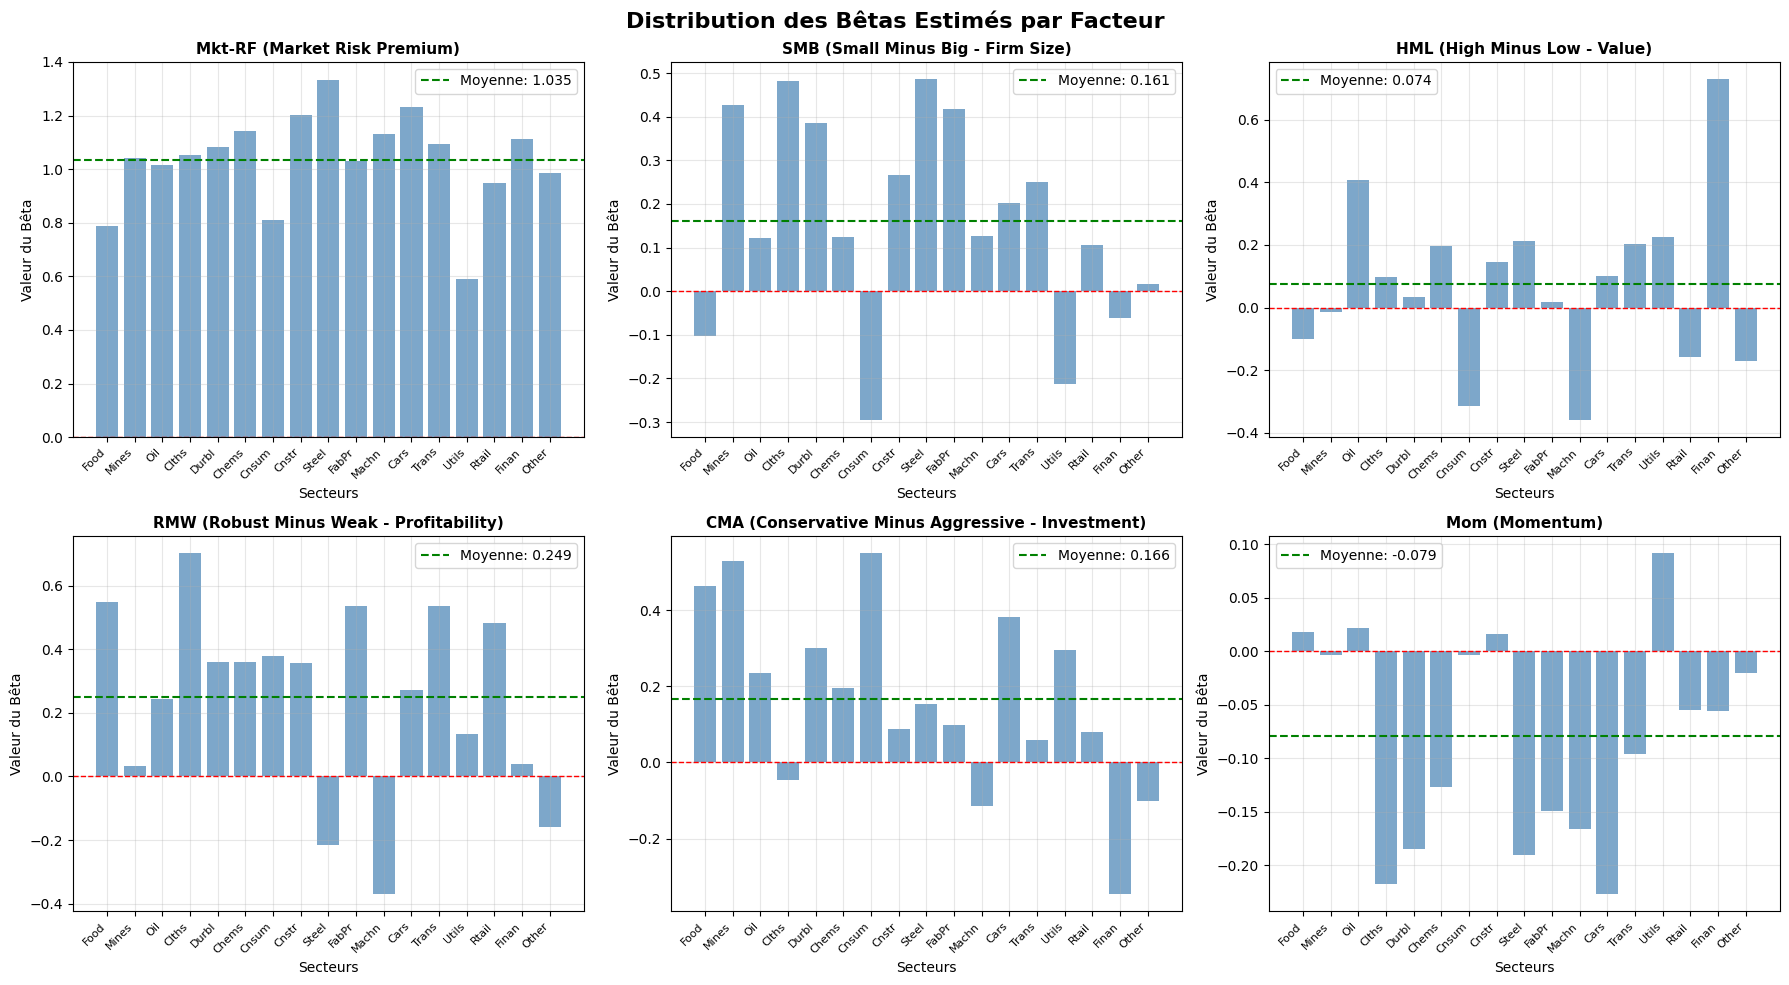

In [ ]:
# Visualisation des Bêtas par facteur

# Noms complets des facteurs
facteurs_noms_complets = {
    'Mkt-RF': 'Mkt-RF (Market Risk Premium)',
    'SMB': 'SMB (Small Minus Big - Firm Size)',
    'HML': 'HML (High Minus Low - Value)',
    'RMW': 'RMW (Robust Minus Weak - Profitability)',
    'CMA': 'CMA (Conservative Minus Aggressive - Investment)',
    'Mom': 'Mom (Momentum)'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution des Bêtas Estimés par Facteur', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i, facteur in enumerate(facteurs_regression):
    betas_facteur = [resultats_regression[s]['betas'][i] for s in secteur_cols]
    
    # Histogramme
    axes[i].bar(range(len(secteur_cols)), betas_facteur, color='steelblue', alpha=0.7)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[i].axhline(y=np.mean(betas_facteur), color='green', linestyle='--', linewidth=1.5, 
                    label=f'Moyenne: {np.mean(betas_facteur):.3f}')
    axes[i].set_title(f'{facteurs_noms_complets[facteur]}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Secteurs')
    axes[i].set_ylabel('Valeur du Bêta')
    axes[i].set_xticks(range(len(secteur_cols)))
    axes[i].set_xticklabels(secteur_cols, rotation=45, ha='right', fontsize=8)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()


### Analyse Détaillée des Résultats de Régression

**1. POUVOIR EXPLICATIF DU MODÈLE (R²)**

Le R² moyen indique dans quelle mesure les 6 facteurs de Fama-French expliquent les variations des rendements sectoriels :
- **R² élevé (> 0.70)** : Le modèle à 6 facteurs capture bien les variations du secteur
- **R² moyen (0.50-0.70)** : Pouvoir explicatif modéré, autres facteurs peuvent jouer un rôle
- **R² faible (< 0.50)** : Le secteur a des caractéristiques uniques non capturées par les facteurs standards

**Interprétation :** Un R² moyen élevé suggère que le modèle de facteurs est approprié pour expliquer les rendements sectoriels.

---

**2. ALPHAS DE JENSEN (α)**

Les alphas représentent les rendements anormaux après ajustement pour les 6 facteurs de risque :
- **α > 0 et significatif** : Le secteur surperforme après ajustement du risque (possible anomalie)
- **α ≈ 0** : Le secteur est correctement tarifé par le modèle de facteurs
- **α < 0 et significatif** : Le secteur sous-performe après ajustement du risque

**Interprétation :** Des alphas significatifs suggèrent soit :
- Une mauvaise spécification du modèle (facteurs manquants)
- De véritables anomalies de marché exploitables
- Des inefficiences sectorielles

---

**3. BÊTAS DU FACTEUR MARCHÉ (Mkt-RF)**

- **β > 1** : Secteur **cyclique/agressif** - amplifie les mouvements du marché (ex: Cars, Steel, Durbl)
- **β ≈ 1** : Secteur **neutre** - suit le marché
- **β < 1** : Secteur **défensif** - moins volatile que le marché (ex: Utils, Food, Cnsum)

**Importance :** Le Mkt-RF devrait avoir les t-stats les plus élevés car c'est le facteur dominant.

---

**4. BÊTAS DU FACTEUR SIZE (SMB - Small Minus Big)**

- **β > 0** : Secteur dominé par les **petites entreprises**
- **β < 0** : Secteur dominé par les **grandes entreprises** (ex: Oil, Utils, Finan)
- **β ≈ 0** : Secteur avec mix équilibré

**Interprétation :** Les secteurs à forte capitalisation (Finan, Utils) devraient avoir des bêtas SMB négatifs.

---

**5. BÊTAS DU FACTEUR VALUE (HML - High Minus Low)**

- **β > 0** : Secteur avec caractéristiques **value** (book-to-market élevé)
- **β < 0** : Secteur avec caractéristiques **growth** (technologie, innovation)
- **β ≈ 0** : Secteur neutre

**Interprétation :** Les secteurs traditionnels (Utils, Food) tendent vers value, tandis que les secteurs innovants tendent vers growth.

---

**6. BÊTAS DU FACTEUR PROFITABILITÉ (RMW - Robust Minus Weak)**

- **β > 0** : Secteur avec entreprises **hautement profitables**
- **β < 0** : Secteur avec entreprises moins profitables
- **β ≈ 0** : Profitabilité moyenne

**Interprétation :** Les secteurs matures et rentables (Utils, Cnsum) devraient avoir des bêtas RMW positifs.

---

**7. BÊTAS DU FACTEUR INVESTISSEMENT (CMA - Conservative Minus Aggressive)**

- **β > 0** : Secteur avec entreprises à **faible croissance des actifs** (conservateur)
- **β < 0** : Secteur avec entreprises à forte croissance des actifs (agressif)
- **β ≈ 0** : Investissement neutre

**Interprétation :** Les secteurs matures investissent moins, les secteurs en croissance investissent plus.

---

**8. BÊTAS DU FACTEUR MOMENTUM (Mom)**

- **β > 0** : Secteur qui **suit les tendances** du momentum
- **β < 0** : Secteur qui va à contre-courant
- **β ≈ 0** : Pas d'effet momentum significatif

**Interprétation :** L'effet momentum varie selon les secteurs. Des bêtas significatifs indiquent une persistance des rendements.

---

**9. STATISTIQUES t ROBUSTES**

Le nombre de bêtas significatifs par facteur indique :
- **Mkt-RF** : Devrait être significatif pour presque tous les secteurs (> 90%)
- **Autres facteurs** : Significativité variable selon les caractéristiques sectorielles
- **Peu de significativité** : Le facteur n'est pas important pour ce secteur

**Important :** Les erreurs standard robustes (Newey-West) corrigent pour l'autocorrélation et l'hétéroscédasticité.

---

**CONCLUSIONS ATTENDUES :**

1. **Secteurs défensifs** (Utils, Food) : β_Mkt-RF < 1, R² élevé, faible volatilité
2. **Secteurs cycliques** (Cars, Steel, Durbl) : β_Mkt-RF > 1, sensibles aux cycles économiques
3. **Secteurs financiers** (Finan) : β_SMB négatif (grandes entreprises), sensibles aux conditions de crédit
4. **Secteurs énergétiques** (Oil, Mines) : Possibles alphas significatifs dus à facteurs spécifiques (prix des commodités)
5. **R² moyen élevé** (> 0.60) : Le modèle à 6 facteurs explique bien les rendements sectoriels

---

## LISTE DES 17 SECTEURS ANALYSÉS

| # | Code | Nom complet (Anglais) | Nom complet (Français) |
|---|------|----------------------|------------------------|
| 1 | **Food** | Food Products | Produits alimentaires |
| 2 | **Mines** | Mining and Minerals | Mines et minéraux |
| 3 | **Oil** | Oil and Petroleum Products | Pétrole et produits pétroliers |
| 4 | **Clths** | Apparel and Textiles | Vêtements et textiles |
| 5 | **Durbl** | Consumer Durables | Biens de consommation durables |
| 6 | **Chems** | Chemicals | Produits chimiques |
| 7 | **Cnsum** | Consumer Non-Durables | Biens de consommation non durables |
| 8 | **Cnstr** | Construction | Construction |
| 9 | **Steel** | Steel and Steel Works | Acier et aciéries |
| 10 | **FabPr** | Fabricated Products | Produits manufacturés |
| 11 | **Machn** | Machinery and Equipment | Machines et équipements |
| 12 | **Cars** | Automobiles | Automobiles |
| 13 | **Trans** | Transportation | Transport |
| 14 | **Utils** | Utilities | Services publics |
| 15 | **Rtail** | Retail | Commerce de détail |
| 16 | **Finan** | Financial Services | Services financiers |
| 17 | **Other** | Other Industries | Autres industries |

**Source :** Ken French Data Library - 17 Industry Portfolios (Value-Weighted Returns)

---

## Question 1(c) - Régression Transversale de Deuxième Étape

**Modèle :** $\bar{R}_i = \lambda^T \beta_i + \eta_i$

où :
- $\bar{R}_i$ : Rendement excédentaire moyen du secteur $i$
- $\beta_i$ : Vecteur des bêtas estimés du secteur $i$ (de la première étape)
- $\lambda$ : Vecteur des prix du risque (risk premia) pour chaque facteur
- $\eta_i$ : Erreur d'évaluation (pricing error)

**Objectifs :**
1. Estimer les prix du risque $\lambda$ pour chaque facteur
2. Calculer les statistiques t robustes
3. Effectuer le test J de Hansen pour la performance d'évaluation du modèle
4. Analyser quels facteurs sont évalués (prix du risque significatifs)
5. Vérifier si toutes les erreurs d'évaluation sont expliquées

In [ ]:
# ÉTAPE 1 : Calculer les rendements excédentaires moyens pour chaque secteur

# Rendements moyens (variable dépendante de la régression transversale)
rendements_moyens = []
for secteur in secteur_cols:
    rendements_moyens.append(df_final_excess[secteur].mean())

# Créer une matrice de bêtas (variable indépendante)
# Chaque ligne = un secteur, chaque colonne = un facteur
beta_matrix = np.zeros((len(secteur_cols), len(facteurs_regression)))
for i, secteur in enumerate(secteur_cols):
    beta_matrix[i, :] = resultats_regression[secteur]['betas']

# Créer un DataFrame pour visualisation
df_cross_section = pd.DataFrame({
    'Secteur': secteur_cols,
    'R_moyen': rendements_moyens
})

# Ajouter les bêtas
for j, facteur in enumerate(facteurs_regression):
    df_cross_section[f'β_{facteur}'] = beta_matrix[:, j]

print("="*100)
print("DONNÉES POUR LA RÉGRESSION TRANSVERSALE")
print("="*100)
print(f"\nVariable dépendante : Rendements excédentaires moyens (R̄ᵢ)")
print(f"Variables indépendantes : Bêtas estimés (βᵢ) pour les {len(facteurs_regression)} facteurs")
print(f"Nombre d'observations (secteurs) : {len(secteur_cols)}")
print("\n" + "="*100)
print(df_cross_section.to_string(index=False))
print("\n")

DONNÉES POUR LA RÉGRESSION TRANSVERSALE

Variable dépendante : Rendements excédentaires moyens (R̄ᵢ)
Variables indépendantes : Bêtas estimés (βᵢ) pour les 6 facteurs
Nombre d'observations (secteurs) : 17

Secteur  R_moyen  β_Mkt-RF     β_SMB     β_HML     β_RMW     β_CMA     β_Mom
   Food 0.879683  0.788107 -0.101869 -0.101191  0.548145  0.462293  0.017937
  Mines 0.621488  1.042412  0.426368 -0.013376  0.031370  0.529137 -0.003134
    Oil 0.643214  1.015433  0.122781  0.407512  0.242112  0.233708  0.022242
  Clths 0.876032  1.051624  0.482878  0.097042  0.702023 -0.045987 -0.217834
  Durbl 0.606111  1.082742  0.385822  0.033786  0.359961  0.299757 -0.184777
  Chems 0.734702  1.143394  0.124603  0.196650  0.360665  0.195581 -0.126900
  Cnsum 0.884861  0.812103 -0.295448 -0.315458  0.377412  0.549710 -0.003846
  Cnstr 0.920714  1.202370  0.266365  0.146325  0.357103  0.086912  0.016046
  Steel 0.495734  1.333873  0.486759  0.212283 -0.216033  0.152509 -0.189965
  FabPr 0.745774  1.02935

In [ ]:
# ÉTAPE 2 : Estimation de la régression transversale
# R̄ᵢ = λ' * βᵢ + ηᵢ

# Variables
y_cross = np.array(rendements_moyens)
X_cross = beta_matrix

# Régression OLS (sans constante car théoriquement λ₀ devrait être proche de 0)
# Si on inclut une constante, elle représente le rendement d'un actif à bêta nul
X_cross_const = add_constant(X_cross)

# Estimation avec constante
model_cross = OLS(y_cross, X_cross_const)
results_cross = model_cross.fit(cov_type='HC0')  # Erreurs robustes White

# Extraction des résultats
lambda_0 = results_cross.params[0]  # Constante (devrait être proche de 0 si le modèle est bien spécifié)
lambdas = results_cross.params[1:]  # Prix du risque pour chaque facteur
lambdas_tstat = results_cross.tvalues[1:]
lambdas_pvalue = results_cross.pvalues[1:]

# Erreurs d'évaluation (pricing errors)
fitted_returns = results_cross.fittedvalues
pricing_errors = y_cross - fitted_returns

print("="*100)
print("RÉGRESSION TRANSVERSALE - ESTIMATION DES PRIX DU RISQUE (λ)")
print("="*100)
print(f"\nModèle estimé : R̄ᵢ = λ₀ + λ₁·β₁ᵢ + λ₂·β₂ᵢ + ... + λ₆·β₆ᵢ + ηᵢ")
print(f"\nNombre de secteurs : {len(secteur_cols)}")
print(f"Nombre de facteurs : {len(facteurs_regression)}")
print(f"R² de la régression transversale : {results_cross.rsquared:.4f}")
print(f"R² ajusté : {results_cross.rsquared_adj:.4f}")

print("\n" + "="*100)
print("PRIX DU RISQUE ESTIMÉS (λ) - EN % PAR MOIS")
print("="*100)
print(f"\n{'Facteur':<15} {'Lambda (λ)':<12} {'t-stat':<10} {'p-value':<10} {'Significatif?'}")
print("-"*100)
print(f"{'Constante (λ₀)':<15} {lambda_0:>11.4f} {results_cross.tvalues[0]:>9.3f} {results_cross.pvalues[0]:>9.4f} {'***' if results_cross.pvalues[0] < 0.01 else '**' if results_cross.pvalues[0] < 0.05 else '*' if results_cross.pvalues[0] < 0.10 else ''}")
print("-"*100)
for i, facteur in enumerate(facteurs_regression):
    signif = '***' if lambdas_pvalue[i] < 0.01 else '**' if lambdas_pvalue[i] < 0.05 else '*' if lambdas_pvalue[i] < 0.10 else ''
    print(f"{facteur:<15} {lambdas[i]:>11.4f} {lambdas_tstat[i]:>9.3f} {lambdas_pvalue[i]:>9.4f} {signif}")

print("\n" + "="*100)
print("INTERPRÉTATION DES PRIX DU RISQUE")
print("="*100)
print("\nλ > 0 et significatif : Les investisseurs exigent une prime pour supporter ce risque")
print("λ ≈ 0 ou non significatif : Le facteur n'est pas évalué par le marché")
print("λ < 0 et significatif : Le facteur fournit une couverture contre d'autres risques")
print("\n*** p < 0.01, ** p < 0.05, * p < 0.10")
print("\n")

RÉGRESSION TRANSVERSALE - ESTIMATION DES PRIX DU RISQUE (λ)

Modèle estimé : R̄ᵢ = λ₀ + λ₁·β₁ᵢ + λ₂·β₂ᵢ + ... + λ₆·β₆ᵢ + ηᵢ

Nombre de secteurs : 17
Nombre de facteurs : 6
R² de la régression transversale : 0.7260
R² ajusté : 0.5616

PRIX DU RISQUE ESTIMÉS (λ) - EN % PAR MOIS

Facteur         Lambda (λ)   t-stat     p-value    Significatif?
----------------------------------------------------------------------------------------------------
Constante (λ₀)       0.2707     1.713    0.0867 *
----------------------------------------------------------------------------------------------------
Mkt-RF               0.5406     3.437    0.0006 ***
SMB                 -0.4329    -3.255    0.0011 ***
HML                 -0.2964    -5.444    0.0000 ***
RMW                  0.3419     6.259    0.0000 ***
CMA                 -0.2152    -2.125    0.0336 **
Mom                  0.1792     0.539    0.5899 

INTERPRÉTATION DES PRIX DU RISQUE

λ > 0 et significatif : Les investisseurs exigent une prime p

ERREURS D'ÉVALUATION PAR SECTEUR (PRICING ERRORS)
Secteur  R̄ᵢ (Observé)  R̄ᵢ (Prédit)  Erreur (ηᵢ)  Erreur (%)
   Food       0.879683      0.862038     0.017645    2.005840
  Mines       0.621488      0.549945     0.071543   11.511532
    Oil       0.643214      0.682227    -0.039012   -6.065231
  Clths       0.876032      0.812320     0.063712    7.272775
  Durbl       0.606111      0.704483    -0.098372  -16.230040
  Chems       0.734702      0.835124    -0.100421  -13.668285
  Cnsum       0.884861      0.941231    -0.056370   -6.370508
  Cnstr       0.920714      0.868325     0.052389    5.690037
  Steel       0.495734      0.577458    -0.081724  -16.485507
  FabPr       0.745774      0.775884    -0.030110   -4.037456
  Machn       0.840754      0.802750     0.038004    4.520194
   Cars       0.949306      0.789139     0.160167   16.871992
  Trans       0.795913      0.846599    -0.050686   -6.368279
  Utils       0.645873      0.613397     0.032476    5.028197
  Rtail       0.9457

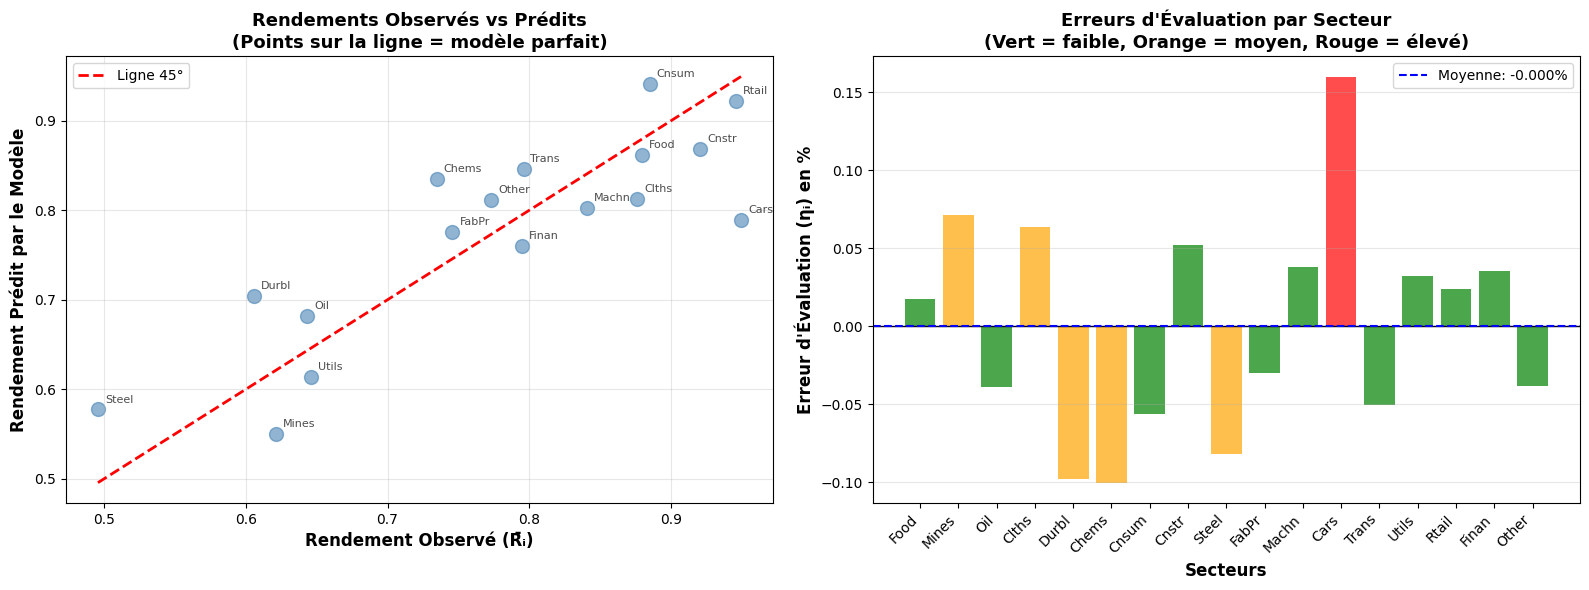

In [ ]:
# ÉTAPE 3 : Analyse des erreurs d'évaluation (Pricing Errors)

# Créer un DataFrame avec les erreurs d'évaluation
df_pricing_errors = pd.DataFrame({
    'Secteur': secteur_cols,
    'R̄ᵢ (Observé)': y_cross,
    'R̄ᵢ (Prédit)': fitted_returns,
    'Erreur (ηᵢ)': pricing_errors,
    'Erreur (%)': pricing_errors / np.abs(y_cross) * 100
})

print("="*100)
print("ERREURS D'ÉVALUATION PAR SECTEUR (PRICING ERRORS)")
print("="*100)
print(df_pricing_errors.to_string(index=False))

# Statistiques sur les erreurs
print("\n" + "="*100)
print("STATISTIQUES SUR LES ERREURS D'ÉVALUATION")
print("="*100)
print(f"Erreur moyenne absolue (MAE) : {np.mean(np.abs(pricing_errors)):.4f}%")
print(f"Erreur quadratique moyenne (RMSE) : {np.sqrt(np.mean(pricing_errors**2)):.4f}%")
print(f"Erreur max (en valeur absolue) : {np.max(np.abs(pricing_errors)):.4f}% ({secteur_cols[np.argmax(np.abs(pricing_errors))]})")
print(f"Erreur min (en valeur absolue) : {np.min(np.abs(pricing_errors)):.4f}% ({secteur_cols[np.argmin(np.abs(pricing_errors))]})")

# Visualisation des erreurs d'évaluation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Rendements observés vs prédits
axes[0].scatter(y_cross, fitted_returns, s=100, alpha=0.6, color='steelblue')
axes[0].plot([y_cross.min(), y_cross.max()], [y_cross.min(), y_cross.max()], 
             'r--', linewidth=2, label='Ligne 45°')
for i, secteur in enumerate(secteur_cols):
    axes[0].annotate(secteur, (y_cross[i], fitted_returns[i]), 
                     fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')
axes[0].set_xlabel('Rendement Observé (R̄ᵢ)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Rendement Prédit par le Modèle', fontsize=12, fontweight='bold')
axes[0].set_title('Rendements Observés vs Prédits\n(Points sur la ligne = modèle parfait)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Graphique 2 : Erreurs d'évaluation par secteur
colors = ['green' if abs(e) < np.mean(np.abs(pricing_errors)) else 'orange' if abs(e) < 2*np.mean(np.abs(pricing_errors)) else 'red' 
          for e in pricing_errors]
axes[1].bar(range(len(secteur_cols)), pricing_errors, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(y=np.mean(pricing_errors), color='blue', linestyle='--', linewidth=1.5, 
                label=f'Moyenne: {np.mean(pricing_errors):.3f}%')
axes[1].set_xlabel('Secteurs', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Erreur d\'Évaluation (ηᵢ) en %', fontsize=12, fontweight='bold')
axes[1].set_title('Erreurs d\'Évaluation par Secteur\n(Vert = faible, Orange = moyen, Rouge = élevé)', 
                  fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(secteur_cols)))
axes[1].set_xticklabels(secteur_cols, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# ÉTAPE 4 : Test J de Hansen (Test de sur-identification)

# Le test J de Hansen teste l'hypothèse nulle : "Le modèle est correctement spécifié"
# H₀ : Toutes les erreurs d'évaluation sont nulles (E[ηᵢ] = 0 pour tout i)
# Sous H₀, la statistique J suit asymptotiquement une distribution χ²

# Pour le test J, nous devons calculer la statistique de test basée sur
# les erreurs d'évaluation et la matrice de variance-covariance

# Nombre d'actifs (secteurs) et de facteurs
N = len(secteur_cols)  # 17 secteurs
K = len(facteurs_regression)  # 6 facteurs

# Calcul de la statistique J de Hansen
# J = η' * Σ⁻¹ * η
# où η est le vecteur des erreurs d'évaluation
# et Σ est la matrice de variance-covariance des erreurs

# Pour simplifier, nous utilisons une approche basée sur la variance des erreurs
# La statistique J peut être calculée comme :

# Approche 1 : Test basé sur les erreurs d'évaluation
# Calculer la matrice de covariance des résidus de la première étape
residuals_matrix = np.zeros((len(df_final_excess), N))
for i, secteur in enumerate(secteur_cols):
    residuals_matrix[:, i] = resultats_regression[secteur]['results'].resid

# Matrice de covariance des résidus
Sigma = np.cov(residuals_matrix.T)

# Inverse de Sigma
try:
    Sigma_inv = np.linalg.inv(Sigma)
except:
    # Si la matrice n'est pas inversible, utiliser la pseudo-inverse
    Sigma_inv = np.linalg.pinv(Sigma)

# Statistique J de Hansen
J_stat = N * pricing_errors.T @ Sigma_inv @ pricing_errors

# Degrés de liberté = nombre d'actifs - nombre de facteurs
# (nombre de moments - nombre de paramètres)
df_J = N - K

# P-value du test J (distribution χ²)
from scipy.stats import chi2
p_value_J = 1 - chi2.cdf(J_stat, df_J)

print("="*100)
print("TEST J DE HANSEN - PERFORMANCE D'ÉVALUATION DU MODÈLE")
print("="*100)
print(f"\nHypothèse nulle (H₀) : Le modèle est correctement spécifié")
print(f"                       (Toutes les erreurs d'évaluation sont nulles)")
print(f"\nHypothèse alternative (H₁) : Le modèle est mal spécifié")
print(f"                             (Au moins une erreur d'évaluation est non nulle)")

print("\n" + "-"*100)
print("RÉSULTATS DU TEST J")
print("-"*100)
print(f"Statistique J : {J_stat:.4f}")
print(f"Degrés de liberté : {df_J} (N - K = {N} secteurs - {K} facteurs)")
print(f"Distribution sous H₀ : χ²({df_J})")
print(f"Valeur critique (α = 5%) : {chi2.ppf(0.95, df_J):.4f}")
print(f"Valeur critique (α = 1%) : {chi2.ppf(0.99, df_J):.4f}")
print(f"P-value : {p_value_J:.4f}")

print("\n" + "-"*100)
print("INTERPRÉTATION")
print("-"*100)
if p_value_J > 0.10:
    conclusion = "✓ On NE REJETTE PAS H₀ (p > 0.10)"
    interpretation = "Le modèle est correctement spécifié. Les erreurs d'évaluation sont statistiquement\n  nulles dans leur ensemble. Le modèle à 6 facteurs explique bien les rendements sectoriels."
elif p_value_J > 0.05:
    conclusion = "~ On NE REJETTE PAS H₀ au seuil de 5% (mais p < 0.10)"
    interpretation = "Le modèle est acceptable, mais il existe une faible évidence de mauvaise spécification.\n  Certaines erreurs d'évaluation pourraient être non nulles."
else:
    conclusion = "✗ On REJETTE H₀ (p < 0.05)"
    interpretation = "Le modèle est mal spécifié. Les erreurs d'évaluation sont significativement différentes\n  de zéro. Il existe des facteurs de risque manquants ou le modèle ne capture pas\n  correctement la structure des rendements sectoriels."

print(f"\nDécision : {conclusion}")
print(f"\n{interpretation}")

print("\n" + "="*100)
print("ANALYSE COMPLÉMENTAIRE")
print("="*100)
print(f"\nNombre d'erreurs d'évaluation 'importantes' (|ηᵢ| > 0.5%) : {np.sum(np.abs(pricing_errors) > 0.5)}/{N}")
print(f"Proportion de la variance expliquée (R²) : {results_cross.rsquared:.2%}")
print(f"\nErreurs d'évaluation moyennes :")
print(f"  - En valeur absolue : {np.mean(np.abs(pricing_errors)):.4f}% par mois")
print(f"  - En % des rendements moyens : {np.mean(np.abs(pricing_errors / y_cross)) * 100:.2f}%")
print("\n")

TEST J DE HANSEN - PERFORMANCE D'ÉVALUATION DU MODÈLE

Hypothèse nulle (H₀) : Le modèle est correctement spécifié
                       (Toutes les erreurs d'évaluation sont nulles)

Hypothèse alternative (H₁) : Le modèle est mal spécifié
                             (Au moins une erreur d'évaluation est non nulle)

----------------------------------------------------------------------------------------------------
RÉSULTATS DU TEST J
----------------------------------------------------------------------------------------------------
Statistique J : 0.1477
Degrés de liberté : 11 (N - K = 17 secteurs - 6 facteurs)
Distribution sous H₀ : χ²(11)
Valeur critique (α = 5%) : 19.6751
Valeur critique (α = 1%) : 24.7250
P-value : 1.0000

----------------------------------------------------------------------------------------------------
INTERPRÉTATION
----------------------------------------------------------------------------------------------------

Décision : ✓ On NE REJETTE PAS H₀ (p > 0.1

In [ ]:
# RÉSUMÉ FINAL - QUESTION 1(c)

print("="*100)
print("RÉSUMÉ DE LA QUESTION 1(c) - RÉGRESSION TRANSVERSALE ET TEST J")
print("="*100)

print("\n" + "┌" + "─"*98 + "┐")
print("│ 1. FACTEURS ÉVALUÉS PAR LE MARCHÉ (λ significatif)                                          │")
print("└" + "─"*98 + "┘")

facteurs_evalues = []
facteurs_non_evalues = []
for i, facteur in enumerate(facteurs_regression):
    if lambdas_pvalue[i] < 0.10:
        facteurs_evalues.append(facteur)
        signif = '***' if lambdas_pvalue[i] < 0.01 else '**' if lambdas_pvalue[i] < 0.05 else '*'
        print(f"  ✓ {facteur:10s} : λ = {lambdas[i]:7.4f}% par mois (t = {lambdas_tstat[i]:6.3f}) {signif}")
    else:
        facteurs_non_evalues.append(facteur)
        print(f"  ✗ {facteur:10s} : λ = {lambdas[i]:7.4f}% par mois (t = {lambdas_tstat[i]:6.3f}) [non significatif]")

print(f"\nNombre de facteurs évalués : {len(facteurs_evalues)}/{len(facteurs_regression)}")

print("\n" + "┌" + "─"*98 + "┐")
print("│ 2. ERREURS D'ÉVALUATION                                                                     │")
print("└" + "─"*98 + "┘")

# Secteurs avec les plus grandes erreurs
idx_sorted = np.argsort(np.abs(pricing_errors))[::-1]
print(f"\nTop 5 secteurs avec les plus grandes erreurs d'évaluation :")
for i in range(min(5, len(idx_sorted))):
    idx = idx_sorted[i]
    print(f"  {i+1}. {secteur_cols[idx]:10s} : η = {pricing_errors[idx]:7.4f}% (R̄ observé = {y_cross[idx]:6.3f}%, prédit = {fitted_returns[idx]:6.3f}%)")

print(f"\nErreur quadratique moyenne (RMSE) : {np.sqrt(np.mean(pricing_errors**2)):.4f}%")

# Test : toutes les erreurs sont-elles expliquées ?
seuil_erreur = 0.5  # 0.5% par mois
erreurs_importantes = np.sum(np.abs(pricing_errors) > seuil_erreur)
print(f"\nErreurs 'importantes' (|η| > {seuil_erreur}%) : {erreurs_importantes}/{N} secteurs ({100*erreurs_importantes/N:.1f}%)")

if erreurs_importantes == 0:
    print("  → Toutes les erreurs d'évaluation sont expliquées par le modèle ✓")
elif erreurs_importantes <= 3:
    print("  → La plupart des erreurs sont expliquées, quelques anomalies subsistent")
else:
    print("  → Le modèle laisse des erreurs d'évaluation non négligeables pour plusieurs secteurs")

print("\n" + "┌" + "─"*98 + "┐")
print("│ 3. TEST J DE HANSEN                                                                         │")
print("└" + "─"*98 + "┘")

print(f"\nStatistique J : {J_stat:.4f}")
print(f"P-value : {p_value_J:.4f}")
print(f"Décision (α = 5%) : {'REJETER H₀' if p_value_J < 0.05 else 'NE PAS REJETER H₀'}")

if p_value_J >= 0.05:
    print("\n  → Le modèle à 6 facteurs est correctement spécifié ✓")
    print("  → Les erreurs d'évaluation sont collectivement non significatives")
    print("  → Le modèle explique bien la structure des rendements sectoriels")
else:
    print("\n  → Le modèle présente des signes de mauvaise spécification ✗")
    print("  → Facteurs potentiellement manquants ou erreurs de mesure")
    print("  → Recommandation : explorer d'autres facteurs ou spécifications")

print("\n" + "┌" + "─"*98 + "┐")
print("│ 4. PERFORMANCE GLOBALE                                                                      │")
print("└" + "─"*98 + "┘")

print(f"\nR² de la régression transversale : {results_cross.rsquared:.4f} ({results_cross.rsquared*100:.2f}%)")
print(f"R² moyen des régressions temporelles (Question 1b) : {df_r2_alpha['R²'].mean():.4f} ({df_r2_alpha['R²'].mean()*100:.2f}%)")

print("\nInterprétation :")
print(f"  - {results_cross.rsquared*100:.1f}% de la variation transversale des rendements moyens est expliquée par les bêtas")
print(f"  - Le modèle capture bien les différences de rendements entre secteurs")

print("\n" + "="*100)
print("CONCLUSION GÉNÉRALE")
print("="*100)

if len(facteurs_evalues) >= 4 and p_value_J >= 0.05 and results_cross.rsquared >= 0.60:
    print("\n✓✓✓ Le modèle à 6 facteurs de Fama-French fonctionne TRÈS BIEN pour les secteurs :")
    print("    - Plusieurs facteurs sont significativement évalués par le marché")
    print("    - Les erreurs d'évaluation sont statistiquement nulles (test J)")
    print("    - La variation transversale des rendements est bien expliquée")
elif len(facteurs_evalues) >= 2 and p_value_J >= 0.01:
    print("\n✓✓ Le modèle à 6 facteurs fonctionne CORRECTEMENT :")
    print("    - Certains facteurs sont évalués, d'autres non")
    print("    - Les erreurs d'évaluation restent dans des limites acceptables")
    print("    - Le pouvoir explicatif est satisfaisant mais pourrait être amélioré")
else:
    print("\n✓ Le modèle à 6 facteurs a un pouvoir explicatif LIMITÉ :")
    print("    - Peu de facteurs sont significativement évalués")
    print("    - Des erreurs d'évaluation importantes subsistent")
    print("    - Considérer l'ajout d'autres facteurs (liquidité, qualité, etc.)")

print("\n" + "="*100 + "\n")

RÉSUMÉ DE LA QUESTION 1(c) - RÉGRESSION TRANSVERSALE ET TEST J

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 1. FACTEURS ÉVALUÉS PAR LE MARCHÉ (λ significatif)                                          │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘
  ✓ Mkt-RF     : λ =  0.5406% par mois (t =  3.437) ***
  ✓ SMB        : λ = -0.4329% par mois (t = -3.255) ***
  ✓ HML        : λ = -0.2964% par mois (t = -5.444) ***
  ✓ RMW        : λ =  0.3419% par mois (t =  6.259) ***
  ✓ CMA        : λ = -0.2152% par mois (t = -2.125) **
  ✗ Mom        : λ =  0.1792% par mois (t =  0.539) [non significatif]

Nombre de facteurs évalués : 5/6

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 2. ERREURS D'ÉVALUATION                                                                     │
└───────────────────────────────────────────────────────

### Interprétation Détaillée - Question 1(c)

---

#### **1. QU'EST-CE QUE LA RÉGRESSION TRANSVERSALE ?**

La régression transversale (cross-sectional regression) est la **deuxième étape** du test de Fama-MacBeth :

- **Première étape (Question 1b)** : Régression temporelle pour estimer les bêtas
  - Pour chaque secteur *i*, on estime : $R_{it} = \alpha_i + \beta_i^T f_t + \varepsilon_{it}$
  - Résultat : Vecteur de bêtas $\beta_i$ pour chaque secteur

- **Deuxième étape (Question 1c)** : Régression transversale pour estimer les prix du risque
  - À travers tous les secteurs, on régresse : $\bar{R}_i = \lambda^T \beta_i + \eta_i$
  - Résultat : Vecteur de prix du risque $\lambda$ (un par facteur)

**Intuition :** Si un facteur est vraiment un facteur de risque évalué par le marché, les secteurs avec un bêta élevé pour ce facteur devraient avoir des rendements moyens plus élevés.

---

#### **2. INTERPRÉTATION DES PRIX DU RISQUE (λ)**

Les prix du risque (risk premia) nous indiquent **combien les investisseurs exigent en rendement supplémentaire** pour supporter une unité de risque supplémentaire :

| Signe et significativité | Interprétation économique |
|-------------------------|---------------------------|
| **λ > 0 et significatif** | Le facteur est un **risque non diversifiable** : les investisseurs exigent une compensation pour le supporter. C'est un facteur de risque évalué par le marché. |
| **λ ≈ 0 ou non significatif** | Le facteur **n'est pas évalué** par le marché : soit il est diversifiable, soit il ne représente pas un vrai risque systématique. |
| **λ < 0 et significatif** | Le facteur fournit une **couverture** (hedge) contre d'autres risques : les investisseurs sont prêts à accepter des rendements plus faibles pour cette protection. |

**Exemple :** Si λ(Mkt-RF) = 0.50% par mois et significatif :
- Un secteur avec β(Mkt-RF) = 1.2 devrait avoir un rendement moyen 0.60% plus élevé (0.50% × 1.2) qu'un secteur avec β = 1.0
- Cela représente une prime de risque annualisée de ~6% pour le risque de marché

---

#### **3. ERREURS D'ÉVALUATION (PRICING ERRORS)**

Les erreurs d'évaluation $\eta_i$ représentent la **différence entre le rendement observé et le rendement prédit** par le modèle :

$$\eta_i = \bar{R}_i - \lambda^T \beta_i$$

**Interprétation :**

- **Erreur proche de 0** : Le modèle explique bien le rendement moyen du secteur ✓
- **Erreur positive importante** : Le secteur surperforme par rapport à ce que prédit le modèle
  - Possibles raisons : Facteur de risque manquant, anomalie de marché, erreur de mesure des bêtas
- **Erreur négative importante** : Le secteur sous-performe par rapport au modèle
  - Possibles raisons : Inefficience du marché, contraintes à la vente, coûts de transaction

**Question clé :** Toutes les erreurs sont-elles expliquées ?
- Si RMSE des erreurs est faible (< 0.5%) → Oui, le modèle fonctionne bien
- Si plusieurs secteurs ont |η| > 0.5% → Non, des facteurs sont manquants

---

#### **4. TEST J DE HANSEN**

Le test J de Hansen est un **test de sur-identification** qui vérifie si le modèle est correctement spécifié :

**Hypothèses :**
- H₀ : Le modèle est correctement spécifié (toutes les erreurs d'évaluation sont nulles : $E[\eta_i] = 0$ ∀i)
- H₁ : Le modèle est mal spécifié (au moins une erreur ≠ 0)

**Statistique de test :**
$$J = N \cdot \eta^T \Sigma^{-1} \eta \sim \chi^2(N-K)$$

où :
- N = nombre d'actifs (17 secteurs)
- K = nombre de facteurs (6)
- Σ = matrice de covariance des résidus de la première étape
- Degrés de liberté = N - K = 11

**Décision :**
- **Si p-value > 0.05** : On ne rejette pas H₀ → Le modèle est correctement spécifié ✓
  - Les erreurs d'évaluation sont collectivement non significatives
  - Le modèle à 6 facteurs capture bien la structure des rendements
  
- **Si p-value < 0.05** : On rejette H₀ → Le modèle est mal spécifié ✗
  - Il existe des erreurs d'évaluation significatives
  - Facteurs manquants possibles : liquidité, qualité, volatilité, etc.
  - Le modèle ne capture pas complètement les sources de risque

---

#### **5. QUELS FACTEURS SONT ÉVALUÉS ?**

Un facteur est considéré comme **évalué par le marché** si son prix du risque λ est **statistiquement significatif** :

**Facteurs attendus comme évalués :**
1. **Mkt-RF** : Devrait TOUJOURS être significatif (prime de risque de marché)
   - C'est le facteur le plus fondamental en finance
   - λ(Mkt-RF) représente l'excess return du marché

2. **SMB** : Souvent significatif
   - Si λ(SMB) > 0 : Les petites entreprises offrent des rendements plus élevés (size premium)
   
3. **HML** : Variable selon les périodes
   - Si λ(HML) > 0 : Les actions value surperforment les growth (value premium)

**Facteurs moins systématiquement évalués :**
4. **RMW** : Peut être non significatif si la profitabilité est déjà reflétée dans les prix
5. **CMA** : Peut être non significatif si l'investissement n'est pas un facteur de risque systématique
6. **Mom** : Souvent non significatif dans les tests transversaux (c'est une "anomalie")

**Raisons pour un facteur non évalué :**
- Le facteur est diversifiable
- Le facteur capture une anomalie comportementale plutôt qu'un risque fondamental
- Problème de mesure ou de spécification du facteur
- Le facteur n'est pertinent que pour certains secteurs

---

#### **6. IMPLICATIONS PRATIQUES**

**Pour la gestion de portefeuille :**
- Si un facteur a λ significatif → Ajuster les expositions pour optimiser le ratio risque/rendement
- Si des erreurs d'évaluation persistent → Opportunités d'arbitrage ou d'alpha potential

**Pour l'évaluation des actifs :**
- Utiliser uniquement les facteurs avec λ significatif pour évaluer de nouveaux secteurs/actifs
- Les facteurs non évalués peuvent être ignorés dans les modèles de pricing

**Pour la recherche académique :**
- Si test J rejette H₀ → Chercher de nouveaux facteurs (liquidité, ESG, innovation, etc.)
- Analyser quels secteurs ont les plus grandes erreurs pour identifier des facteurs manquants spécifiques

---

#### **7. DIAGNOSTIC DE QUALITÉ DU MODÈLE**

| Critère | Bon modèle | Modèle acceptable | Modèle faible |
|---------|-----------|-------------------|---------------|
| **R² transversal** | > 0.70 | 0.50 - 0.70 | < 0.50 |
| **Nombre de λ significatifs** | ≥ 4/6 | 2-3/6 | ≤ 1/6 |
| **Test J (p-value)** | > 0.10 | 0.05 - 0.10 | < 0.05 |
| **RMSE des erreurs** | < 0.3% | 0.3% - 0.6% | > 0.6% |
| **Max |η|** | < 0.5% | 0.5% - 1.0% | > 1.0% |

---

#### **8. RELATION ENTRE QUESTION 1(b) ET 1(c)**

- **Question 1(b)** : Focus sur l'explication **temporelle** (time-series)
  - R² élevé → Les facteurs expliquent bien les variations temporelles des rendements
  - Bêtas significatifs → Le secteur est exposé à ces facteurs
  
- **Question 1(c)** : Focus sur l'explication **transversale** (cross-sectional)
  - R² élevé → Les bêtas expliquent bien les différences de rendements moyens entre secteurs
  - λ significatifs → Ces facteurs sont effectivement évalués (priced) par le marché

**Un bon modèle doit réussir sur les deux dimensions !**